# The Okada model for computing seafloor deformation

This notebook is part of the GeoClaw documentation, see 
 - <http://www.clawpack.org> For general Clawpack documentation,
 - <http://www.clawpack.org/okada.html> for more documentation on the use of the Okada model in  GeoClaw.  
 - <http://www.clawpack.org/apps.html> for information on obtaining the *apps* repository. The source for this notebook is maintained in `$CLAW/apps/notebooks/geoclaw/Okada.ipynb`.
 - <http://www.clawpack.org/dtopotools_module.html>: In GeoClaw the Okada model is implemented in `dtopotools.SubFault.okada`, 
 
## Contents

- <a href="#examples">Examples</a>
- <a href="#szthrust">Typical subduction zone thrust event</a>
- <a href="#strike">Varying the strike</a>
- <a href="#dip">Varying the dip</a>
- <a href="#rake">Varying the rake</a>

## Introduction

The "Okada model" takes as input the slip on a rectangular patch of a fault deep in the earth and produces the resulting deformation of the earth's surface.  For tsunami modeling, we are particularly interested in the vertical motion of the seafloor above the fault. 

The Okada model makes many assumptions that only approximate reality, in particular:
 - The earth is modeled as a perfectly elastic half space.  The slip is uniform on a rectangular patch and a Greens' function solution to the half space problem is integrated to obtain the vertical deformation at the surface of the half plane.  The seafloor topography is ignored in computing the Okada deformation (which is then generally added to the real topography to get the modified topography during the earthquake).
 - The half space is assumed to be isotropic with uniform elastic moduli.  The Poisson ratio is generally taken to be 0.25 and the shear modulus (or rigidity) is constant, often taken to be $4\times 10^{11}$ dyne/cm$^2 = 40$ GPa.
 
Complex earthquake fault surfaces are generally approximated by a subdividing into a set of rectangular subfaults, each of which might have different orientation and slip properties.  The Okada model is applied to each and then the resulting surface deformations are summed.  The Okada model is linear, so that if a single planar fault is split into subfaults the resulting surface deformation should be independent of the number of pieces its split into.

The GeoClaw *dtopotools.Fault* class provides tools for specifying a fault as a collection of *dtopotools.SubFault* objects, and an object of this class has a method *create_dtopography* that applies the Okada model and returns a *dtopotools.DTopography* object expressing the surface deformation.  In this notebook we illustrate the Okada model by working with a fault that consists of a single subfault.

A subfault is specified via the following standard parameters:
 - *length* and *width* of the fault plane (specified in meters below),
 - *latitude* and *longitude* of some point on the fault plane, typically
      either the centroid or the center of the top (shallowest edge),
 - *depth* of the specified point below the sea floor (in meters below),
 - *strike*, the orientation of the top edge, measured in degrees
      clockwise from North, between 0 and 360.  The fault plane dips downward
      to the right when moving along the top edge in the strike direction.
 - *dip*, angle at which the plane dips downward from the top edge, a
      positive angle between 0 and 90 degrees.
 - *rake*, the angle in the fault plane in which the slip occurs,
      measured in degrees counterclockwise from the strike direction.
      Between -180 and 180.
 - *slip > 0*, the distance (measured in meters below) the hanging-wall block moves
      relative to the footwall block, in the direction specified by the rake.
      The "hanging-wall block" is the one above the dipping fault plane (or to the
      right if you move along the fault in the strike direction).
      

For other descriptions and illustrations, see e.g.
 - <http://www.opensha.org/glossary-strikeDipRake> 
 - <http://quakeinfo.ucsd.edu/~gabi/sio15/lectures/Lecture05.html>
 

### Import modules and define some utility functions used below...

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
from clawpack.geoclaw import dtopotools
from clawpack.visclaw.JSAnimation import IPython_display
import clawpack.visclaw.JSAnimation.JSAnimation_frametools as J

In [3]:
def set_fault(strike, dip, rake, depth):
    """
    Set the subfault parameters.
    Most are fixed for the examples below, 
    and only the strike, dip, and rake will be varied.
    """
    subfault = dtopotools.SubFault()
    subfault.strike = strike
    subfault.dip = dip
    subfault.rake = rake
    subfault.length = 100.e3
    subfault.width = 50.e3
    subfault.depth = depth
    subfault.slip = 1.
    subfault.longitude = 0.
    subfault.latitude = 0.
    subfault.coordinate_specification = "top center"

    fault = dtopotools.Fault()
    fault.subfaults = [subfault]
    return fault, subfault

# Create a sample fault and print out some information about it...
fault, subfault = set_fault(0,0,0,5e3)
print "This sample fault has %s meter of slip over a %s by %s km patch" \
       % (subfault.slip,subfault.length/1e3,subfault.width/1e3)
print "With shear modulus %4.1e Pa the seismic moment is %4.1e" % (subfault.mu, subfault.Mo())
print "   corresponding to an earthquake with moment magnitude %s" % fault.Mw()
print "The depth at the top edge of the fault plane is %s km" % (subfault.depth/1e3)

This sample fault has 1.0 meter of slip over a 100.0 by 50.0 km patch
With shear modulus 4.0e+10 Pa the seismic moment is 2.0e+20
   corresponding to an earthquake with moment magnitude 7.50068666378
The depth at the top edge of the fault plane is 5.0 km


In [4]:
def plot_okada(strike, dip, rake, depth, verbose=False):
    """
    Make 3 plots to illustrate the Okada solution.
    """

    fault,subfault = set_fault(strike, dip, rake, depth)
    ax1 = subplot(2,2,1)
    ax2 = subplot(2,2,2)
    ax3 = subplot(2,2,3)
    ax4 = subplot(2,2,4)

    # Subfault projection on surface on ax1:
    ax = fault.plot_subfaults(axes=ax1, plot_rake=True, xylim=[-.5,1.5, -1,1])
    text(0.6,0.8,"Strike = %5.1f" % strike, fontsize=12)
    text(0.6,0.6,"Dip = %5.1f" % dip, fontsize=12)
    text(0.6,0.4,"Rake = %5.1f" % rake, fontsize=12)
    text(0.6,0.2,"Depth = %5.1f km" % (depth/1e3), fontsize=12)
    ax1.set_ylabel('latitude (degrees)')

    # Depth profile on ax3:
    z_top = -subfault.centers[0][2] / 1e3 # convert to km
    z_bottom = -subfault.centers[2][2] / 1e3 # convert to km
    ax3.plot([0,cos(subfault.dip*pi/180.)*subfault.width/1.e3], [z_top, z_bottom])
    ax3.set_xlim(-50,150)
    ax3.set_ylim(-55,0)
    ax3.set_xlabel('distance orthogonal to strike')
    ax3.set_ylabel('depth (km)')
    ax3.set_title('Depth profile')
    
    
    # Grid to use for evaluating and plotting dz
    x = numpy.linspace(-0.5, 1., 101)
    y = numpy.linspace(-1., 1., 101)
    times = [1.]

    # color map of deformation dz on ax2:
    fault.create_dtopography(x,y,times,verbose=verbose)
    dtopo = fault.dtopo
    dtopo.plot_dZ_colors(t=1., axes=ax2)
    
    # transect of dz on ax4:
    dZ = dtopo.dZ[-1,50,:]
    ax4.plot(x,dZ)
    ax4.set_ylim(-0.5,0.5)
    ax4.set_title('Transect of dz along y=0')
    ax4.set_xlabel('Longitude (degrees)')
    ax4.set_ylabel('Seafloor deformation (m)')
    

<div id="examples"></div>
## Examples

<div id="szthrust"></div>
### Typical subduction zone thrust event

For a subduction zone earthquake, the rake is generally close to 90 degrees.  In the first example below we take it to be 80 degrees -- note that the green line on the fault plane extending from the centroid in the rake direction is 80 degrees counterclockwise from north (the strike direction, since *strike = 0*). 

Note that the fault plane plot shows the projection of the fault plane on the flat surface.  It dips down to the right as seen in the depth profile.  The *dip* is 10 degrees and the fault extends from a depth of 5 km at the up-dip edge to about 14 km at the downdip edge.  Note that above the width of the subfault is set to 50 km and that the "Fault planes" plot axes are in degrees.  This fault is located at the equator where 1 degree is approximate 111 km in both directions.

The rock above the fault plane (the hanging block) is moving to the left relative to the lower block (as shown by the green line) and hence the rock above the fault will be compressed to the left and bulge upwards.  The rock to the right is under tension and the surface dips downwards as a result. This can be seen in the "seafloor deformation" plot, where the colors indicate meters of vertical motion.  

The *slip* on this subfault was set to 1 meter above.  Since the Okada model is linear, changing the slip to some other value would simply multiply the deformation by the same factor everywhere.

Making Okada dz for each of 1 subfaults
0..
Done


/Users/rjl/anaconda/envs/jupyter/lib/python2.7/site-packages/matplotlib/axes/_base.py:1057: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  if aspect == 'normal':
/Users/rjl/anaconda/envs/jupyter/lib/python2.7/site-packages/matplotlib/axes/_base.py:1062: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  elif aspect in ('equal', 'auto'):


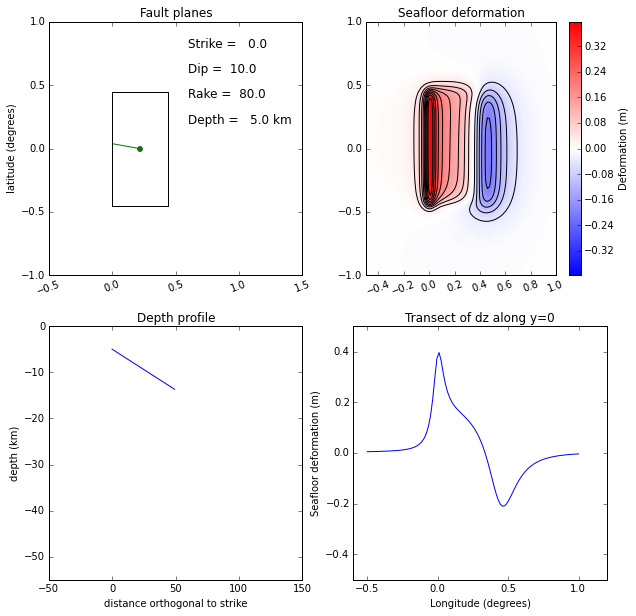

In [5]:
fig=figure(figsize=(10,10))
plot_okada(strike=0, dip=10, rake=80, depth=5e3, verbose=True)

<div id="strike"></div>
## Varying the strike

Changing the strike simply rotates the fault and the resulting deformation. The animation below illustrates this...


In [10]:
plotdir = 'okada_strike_plots'
J.make_plotdir(plotdir, clobber=True)
fig=figure(figsize=(10,10))
for k,strike in enumerate(linspace(0,340,18)):
    clf()
    plot_okada(strike, 10., 80., 5e3)
    J.save_frame(k, plotdir=plotdir, verbose=False)
    
clf()
anim = J.make_anim(plotdir)
anim

Figure files for each frame will be stored in  okada_strike_plots


<div id="dip"></div>
## Varying the dip

When *dip=0* the fault plane is horizontal. If the *rake* is near 90 degrees we expect compression and uplift to the left and subsidence to the right, as illustrated above.  

When the *dip=90* the fault plane is vertical with the hanging-wall block to the right moving upward and the footwall block to the left moving downward.  We then expect to see uplift on the right and subsidence on the left, opposite to what is seen when *dip=0*.  

Note how this transition takes place as the dip is changed...

In [7]:
plotdir = 'okada_dip_plots'
J.make_plotdir(plotdir, clobber=True)
fig=figure(figsize=(10,10))
for k,dip in enumerate(linspace(0,90,10)):
    clf()
    plot_okada(0., dip, 90., 5e3)
    J.save_frame(k, plotdir=plotdir, verbose=False)
    
clf()
anim = J.make_anim(plotdir)
anim

Figure files for each frame will be stored in  okada_dip_plots


<div id="rake"></div>
## Varying the rake

If we fix the *dip* at 10 degrees and vary the direction of slip on the fault plane (the *rake*), we get the following patterns:

In [8]:
plotdir = 'okada_rake_plots'
J.make_plotdir(plotdir, clobber=True)
fig=figure(figsize=(9,9))
for k,rake in enumerate(linspace(-90,90,19)):
    clf()
    plot_okada(0., 10., rake, 5e3)
    J.save_frame(k, plotdir=plotdir, verbose=False)
    
clf()
anim = J.make_anim(plotdir)
anim

Figure files for each frame will be stored in  okada_rake_plots


<div id="depth"></div>
## Varying the depth

If the fault surface is near the surface the surface deformation will be more concentrated near the fault plane than if the fault is deeper, as the next animation illustrates.

Note that the grid used in this example for evaluting the seafloor deformation *dz* does not extend out far enough to capture all of the deformation, particularly for deeper faults!

In [9]:
plotdir = 'okada_depth_plots'
J.make_plotdir(plotdir, clobber=True)
fig=figure(figsize=(9,9))
for k,depth in enumerate(arange(0,40,2)*1e3):
    clf()
    plot_okada(0., 10., 80, depth)
    J.save_frame(k, plotdir=plotdir, verbose=False)
    
clf()
anim = J.make_anim(plotdir)
anim

Figure files for each frame will be stored in  okada_depth_plots
